In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # for placing colorbar

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u

import sunpy.map
import sunpy.data.sample  # This line is only necessary if you want to use sample data
from sunpy.visualization.colormaps import color_tables as ct

plt.rcParams['font.size'] = 5  # This sets the font size to 10 pts, adjust as needed

In [3]:
fits_path1 = '/Users/brandonlpanos/gits/mvts/throw/aia.lev1_euv_12s.2011-11-09T100002Z.131.image.fits'
fits_path2 = '/Users/brandonlpanos/gits/mvts/throw/aia.lev1_euv_12s.2011-11-09T100002Z.193.image.fits'
fits_path3 = '/Users/brandonlpanos/gits/mvts/throw/hmi.m_45s.20111109_100045_TAI.2.magnetogram.fits'
fits_path4 = '/Users/brandonlpanos/gits/mvts/throw/vel/hmi.v_45s.20141213_074845_TAI.2.Dopplergram.fits'
fits_paths = [fits_path1, fits_path2, fits_path3, fits_path4, fits_path1, fits_path2, fits_path3, fits_path4, fits_path1, fits_path2, fits_path3]

In [4]:
def plot_fits_images(fits_paths):
    '''
    fits_paths is a list of paths to fits files
    Plots a grid of images from the fits files
    '''
    
    fig = plt.figure(figsize=(15, 12))
    axs = []

    for idx, fits_path in enumerate(fits_paths):
        with fits.open(fits_path) as hdul:
            header = hdul[1].header
            data = hdul[1].data

        wcs_sliced = WCS(header, naxis=[1, 2])

        if idx < len(axs):
            ax = axs[idx]
        else:
            ax = fig.add_subplot(3, 4, idx+1, projection=wcs_sliced)
            axs.append(ax)

        obs_date_time = header.get('DATE-OBS', "Unknown Date")
        vmin_val, vmax_val = np.percentile(data, [1, 99])

        if 'aia' in fits_path:
            data = data * header['DN_GAIN'] 
            vmin_val, vmax_val = np.percentile(data, [1, 99])
            aia_map = sunpy.map.Map(data, header)
            channel = int(aia_map.meta['wavelnth'])
            channel_wavelength = channel * u.angstrom
            cmap = ct.aia_color_table(channel_wavelength)
            title = f'AIA {channel} Date-Time: {obs_date_time}'
            c_bar_label = 'Intensity [photons / s]'
        elif 'magnetogram' in fits_path:
            cmap = 'binary_r'
            title = f'Magnetogram Date-Time: {obs_date_time}'
            c_bar_label = 'Magnetic Field Strength [Gauss]'
        elif 'Dopplergram' in fits_path:
            cmap = 'coolwarm'
            title = f'Dopplergram Date-Time: {obs_date_time}'
            data = data - np.mean(data)
            c_bar_label = 'Velocity [m/s]'

        ax.imshow(data, origin='lower', cmap=cmap, vmin=vmin_val, vmax=vmax_val, alpha=0.7)
        ax.set_title(title)
        ax.coords.grid(True, color='white', ls='--')
        ax.coords[0].set_axislabel('Solar X [arcsec]')
        ax.coords[1].set_axislabel('Solar Y [arcsec]')

        # Using inset_axes to create space for the colorbar within the ax
        cbar_ax = inset_axes(ax, width='3%', height='100%', loc='lower left',
                             bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        cbar = plt.colorbar(ax.images[0], cax=cbar_ax, orientation='vertical')
        cbar.set_label(c_bar_label)

    plt.subplots_adjust(hspace=-0.6, wspace=0.5)  # adjust these values as needed
    # plt.savefig('grid_of_images.png', dpi=300)
    plt.show()
    
    return None

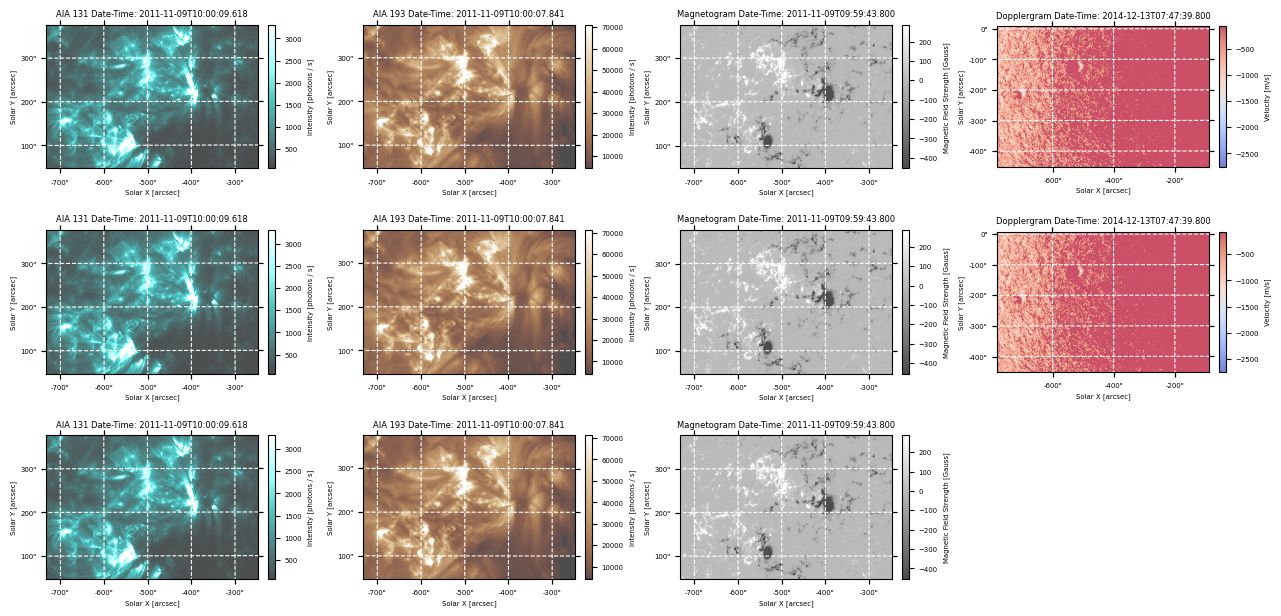

In [5]:
# Example usage:
plot_fits_images(fits_paths)